In [1]:
import sqlite3
import pandas as pd

import config

In [83]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = sqlite3.connect(config.mlb_db_path)

In [3]:
roster = pd.read_sql(sql='select * from starters', con=conn)
subs = pd.read_sql(sql='select * from substitutions', con=conn)
plays = pd.read_sql(sql='select * from plays', con=conn)
data = pd.read_sql(sql='select * from game_data', con=conn)

# Game by Game

In [8]:
game_id = plays.loc[6258037]['game_id']

In [59]:
def pitcher_vs_batter(game_id):
    plays_ = plays[plays['game_id'] == game_id]
    
    # for half 0 == away and 1 == home
    p0 = plays[(plays['game_id'] == game_id)
              &(plays['half'] == 0)]
    p1 = plays[(plays['game_id'] == game_id)
              &(plays['half'] == 1)]
    
    # Select starting pitchers
    sp0 = roster[(roster['game_id'] == game_id)
                &(roster['position'] == 1)
                &(roster['team_HA'] == 0)]
    sp1 = roster[(roster['game_id'] == game_id)
                &(roster['position'] == 1)
                &(roster['team_HA'] == 1)]
    
    # Select pitching subs
    ps_0 = subs[(subs['game_id'] == game_id)
                 & (subs['position'] == 1)
                 & (subs['team_HA'] == 1)]
    ps_1 = subs[(subs['game_id'] == game_id) 
                 & (subs['position'] == 1)
                 & (subs['team_HA'] == 0)]
    for df in [ps_0,ps_1]:
        df.rename(columns={'player_id':'pitcher_id',
                         'team_HA':'pitcher_team'},
                         inplace=True)
    ## Apply pitchers to play dataframe
    # Set starting pitchers
    p0.loc[p0.index[0],'pitcher_id'] = sp0['player_id'].tolist()[0]
    p1.loc[p1.index[0],'pitcher_id'] = sp1['player_id'].tolist()[0]
    # Append pitching subs
    p0_ = p0.append(ps_0[['pitcher_id','eventcount']]).sort_values('eventcount')
    p1_ = p1.append(ps_1[['pitcher_id','eventcount']]).sort_values('eventcount')
    # Fill and finalize play pitch dataframe
    p0_['pitcher_id'] = p0_['pitcher_id'].fillna(method='ffill')
    p1_['pitcher_id'] = p1_['pitcher_id'].fillna(method='ffill')
    game_final = p0_.append(p1_).dropna(subset=['game_id']).sort_values('eventcount')
    
    return game_final

In [ ]:
pp = pitcher_vs_batter(game_id=game_id)

In [71]:
%timeit -r 5 pitcher_vs_batter(game_id=game_id)

3.87 s ± 847 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [72]:
# HOURS to run all games
3.87 * len(set(plays['game_id']))/ 60/60

118.06940000000002

# Full DB

In [115]:
def add_pitch_to_plays():
    roster_ = roster[roster['position'] == 1]
    roster_['eventcount'] = -1
    subs_ = subs[subs['position'] == 1]

    pitchers = roster_.append(subs_)
    pitchers['team_HA'] = abs(pitchers['team_HA'] - 1)
    pitchers_ = pitchers[['eventcount','game_id',
                          'player_id','team_HA']].rename(columns={'player_id':'pitcher_id',
                                                                  'team_HA':'half'})

    full = plays.append(pitchers_)
    full_ = full.sort_values(['game_id','half','eventcount'])
    full_ = full_[~full_['game_id'].str.contains('"')]
    full_['pitcher_id'] = full_['pitcher_id'].fillna(method='ffill')
    final = full_.dropna(subset=['inning'])
    return final

In [ ]:
final = add_pitch_to_plays()

In [156]:
final.head()

,count,event,eventcount,game_id,half,inning,pitcher_id,pitches,player_id,event_s
1502436,11,9/F89M,0,ANA199704020,0,1.0,langm001,FBX,garcn001,9
1502437,00,D9/L9LM/R46,1,ANA199704020,0,1.0,langm001,X,valej002,D9
1502438,31,W,2,ANA199704020,0,1.0,langm001,CBBBB,vaugm001,W
1502439,11,8/F8RXD/R6.2-3,3,ANA199704020,0,1.0,langm001,SBX,stanm002,8
1502440,10,64(1)/FO/G6,4,ANA199704020,0,1.0,langm001,B1X,naeht001,64(1)


In [169]:
final['batting_avg'] = final['slugging'] = final['event_s']

In [117]:
%timeit -r 5 add_pitch_to_plays()

39.6 s ± 4.54 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


# Baseball stats functions

In [223]:
def batting_avg(event_series):
    result = 0
    count = 0
    feed_dict = {'S':(1,1),
                 'D':(1,1),
                 'T':(1,1),
                 'HR':(1,1),
                 'K':(1,0),
                 'W':(0,0)}
    for play_str in event_series:
        found = False
        for play_key, play_vals in feed_dict.items():
            if play_key in play_str:
                count += play_vals[0]
                result += play_vals[1]
                found = True
        if found == False:
            count += 1 
    if count == 0:
        return 0
    else:
        return float(result)/float(count)

In [284]:
def slugging(event_series):
    result = 0
    count = 0
    feed_dict = {'S':(1,1),
                 'D':(1,2),
                 'T':(1,3),
                 'HR':(1,4),
                 'K':(1,0),
                 'W':(0,0)}
    for play_str in event_series:
        found = False
        for play_key, play_vals in feed_dict.items():
            if play_key in play_str:
                count += play_vals[0]
                result += play_vals[1]
                found = True
        if found == False:
            count += 1 
    if count == 0:
        return 0
    else:
        return float(result)/float(count)

In [295]:
def singles(event_series):
    count = 0
    for event_str in event_series:
        if 'S' in event_str:
            count += 1
        else:
            pass
    return count
def doubles(event_series):
    count = 0
    for event_str in event_series:
        if 'D' in event_str:
            count += 1
        else:
            pass
    return count
def triples(event_series):
    count = 0
    for event_str in event_series:
        if 'T' in event_str:
            count += 1
        else:
            pass
    return count
def home_runs(event_series):
    count = 0
    for event_str in event_series:
        if 'HR' in event_str:
            count += 1
        else:
            pass
    return count
def walks(event_series):
    count = 0
    for event_str in event_series:
        if 'W' in event_str:
            count += 1
        else:
            pass
    return count

In [ ]:
final['year'] = final['game_id'].apply(lambda x: int(x[3:7]))

# Batter vs Pitcher

In [304]:
ba = final.groupby(['player_id','pitcher_id']).agg({'batting_avg':[singles,doubles,triples,home_runs,walks],
                                                    'pitches':'count'})

In [306]:
ba['hits'] = ba['batting_avg'][['singles','doubles','triples','home_runs']].sum(axis=1)

In [308]:
ba['ab'] = ba['pitches']

In [184]:
import matplotlib.pyplot as plt

In [185]:
%matplotlib inline

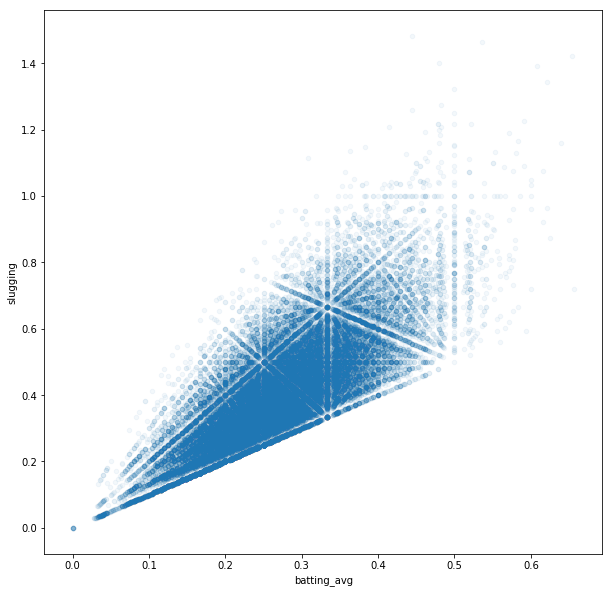

In [226]:
ba[ba['pitches'] > 25].plot(kind='scatter',
                            x='batting_avg',
                            y='slugging',
                            figsize=(10,10),
                            alpha=.05)

# Batter

In [340]:
bat = final.groupby(['player_id','year']).agg({'batting_avg':[singles,doubles,triples,home_runs,walks],
                                                     'pitches':'count'})
bat[('batting_avg','hits')] = bat['batting_avg'][['singles','doubles','triples','home_runs']].sum(axis=1)
bat[('batting_avg','ab')] = bat['pitches']['count'] - bat['batting_avg']['walks']

bat_ = bat['batting_avg'][['hits','ab']].unstack(level=0).cumsum().stack(
    level=1).reset_index().sort_values('year')

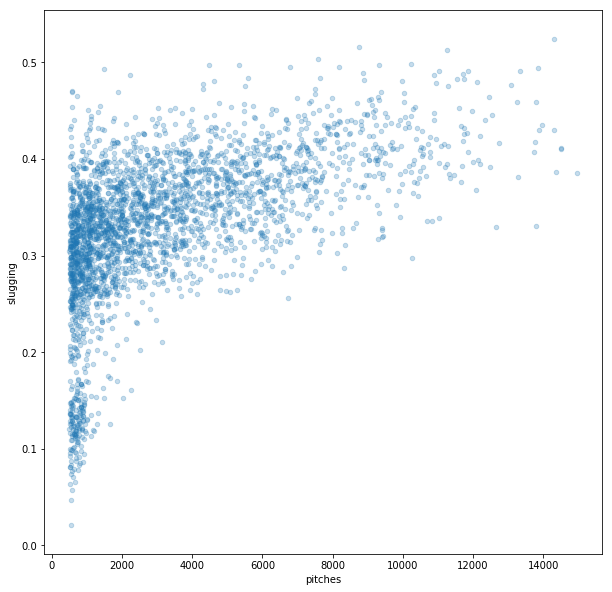

In [234]:
f_[f_['pitches'] > 500].plot(kind='scatter',
                            x='pitches',
                            y='slugging',
                            figsize=(10,10),
                            alpha=.25)

## Running batting avg by "n" appearance 

In [423]:
n = 50

In [419]:
batting = final.copy()

In [420]:
batting['singles'] = batting['event_s'].apply(singles)
batting['doubles'] = batting['event_s'].apply(doubles)
batting['triples'] = batting['event_s'].apply(triples)
batting['home_runs'] = batting['event_s'].apply(home_runs)
batting['walks'] = batting['event_s'].apply(walks)

In [421]:
batting['hits'] = batting[['singles','doubles','triples','home_runs']].sum(axis=1)
batting['ab'] = 1 - batting['walks']

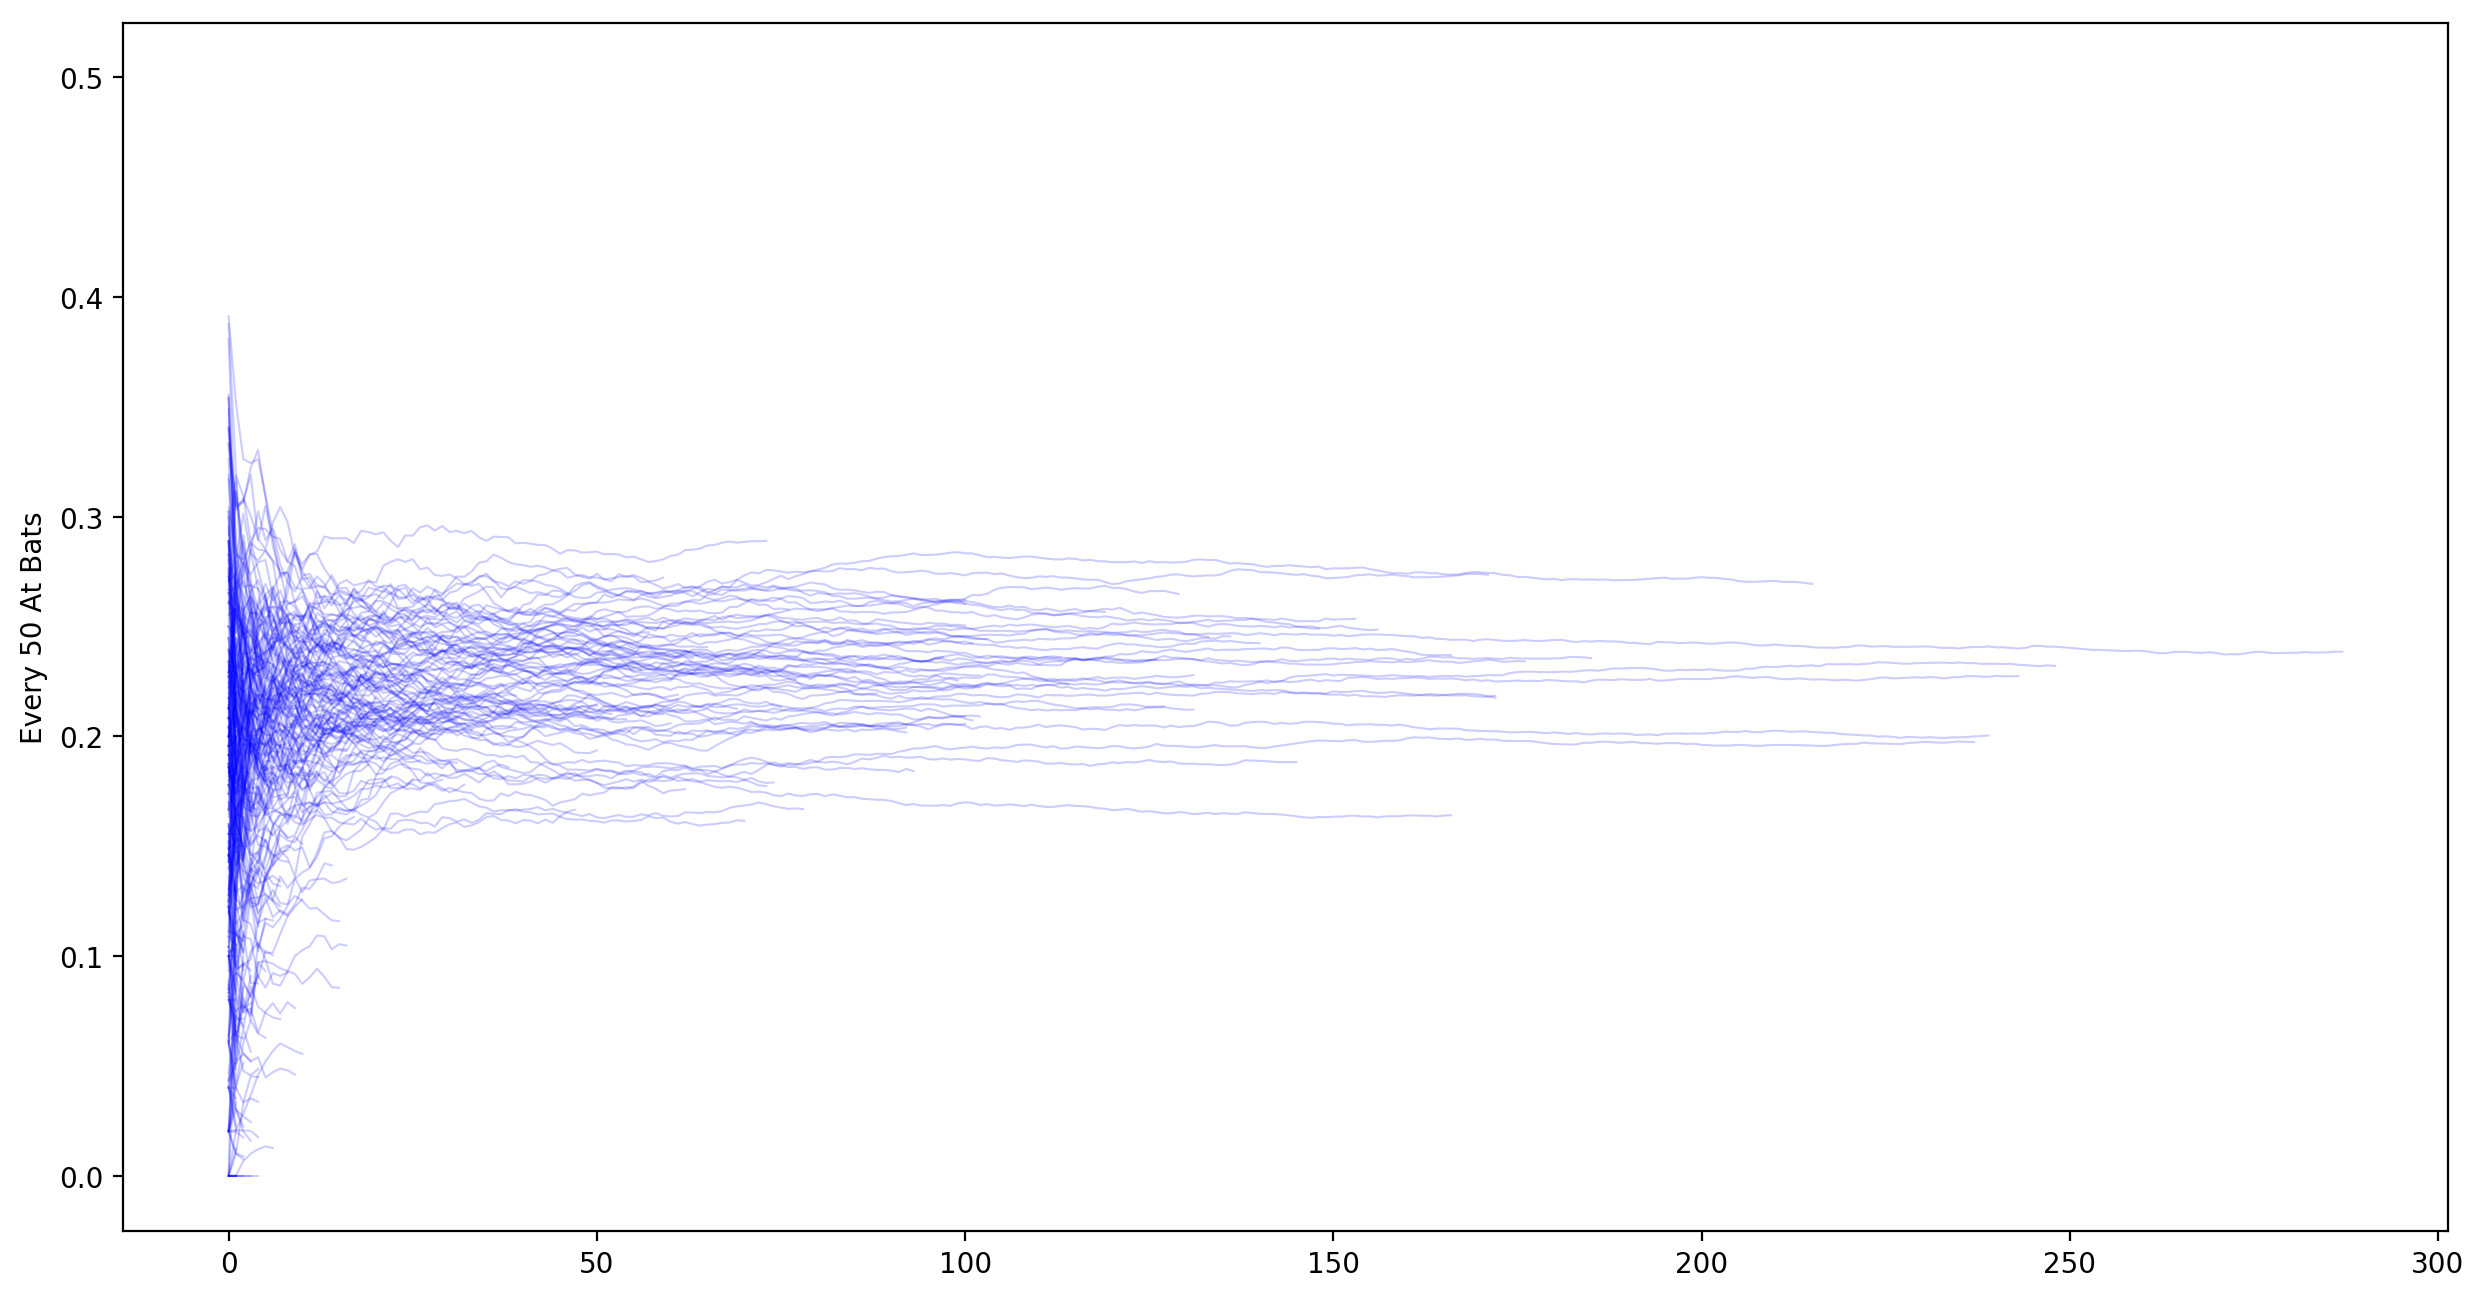

In [425]:
fig, ax1= plt.subplots(figsize=(15,8), dpi=200)
for batter in list(set(batting['player_id'].tolist()))[::20]:
    single_bat = batting[batting['player_id'] == batter]
    single_bat = single_bat.reset_index()
    del single_bat['index']
    single_bat_ = single_bat.groupby(single_bat.index // n).sum().cumsum()
    single_bat_['avg'] = single_bat_['hits']/single_bat_['ab']
    X = single_bat_.index
    Y = single_bat_['avg']
    ax1.plot(X, Y, alpha=.2, color='blue', lw=.75)
    ax1.set_ylabel('Cumulitive Batting Average')
    ax1.set_xlabel('Every {} At Bats'.format(n))

# Pitcher

In [348]:
pit = final.groupby(['pitcher_id','year']).agg({'batting_avg':[singles,doubles,triples,home_runs,walks],
                                                'pitches':'count'})
pit[('batting_avg','hits')] = pit['batting_avg'][['singles','doubles','triples','home_runs']].sum(axis=1)
pit[('batting_avg','ab')] = pit['pitches']['count'] - pit['batting_avg']['walks']

pit_ = pit['batting_avg'][['hits','ab']].unstack(level=0).cumsum().stack(
    level=1).reset_index().sort_values('year')

In [349]:
pit_.head()

,year,pitcher_id,hits,ab
0,1969,abert101,82.0,419.0
244,1969,palmj001,147.0,741.0
243,1969,otood101,5.0,22.0
242,1969,ostec103,310.0,1339.0
241,1969,osind101,63.0,308.0


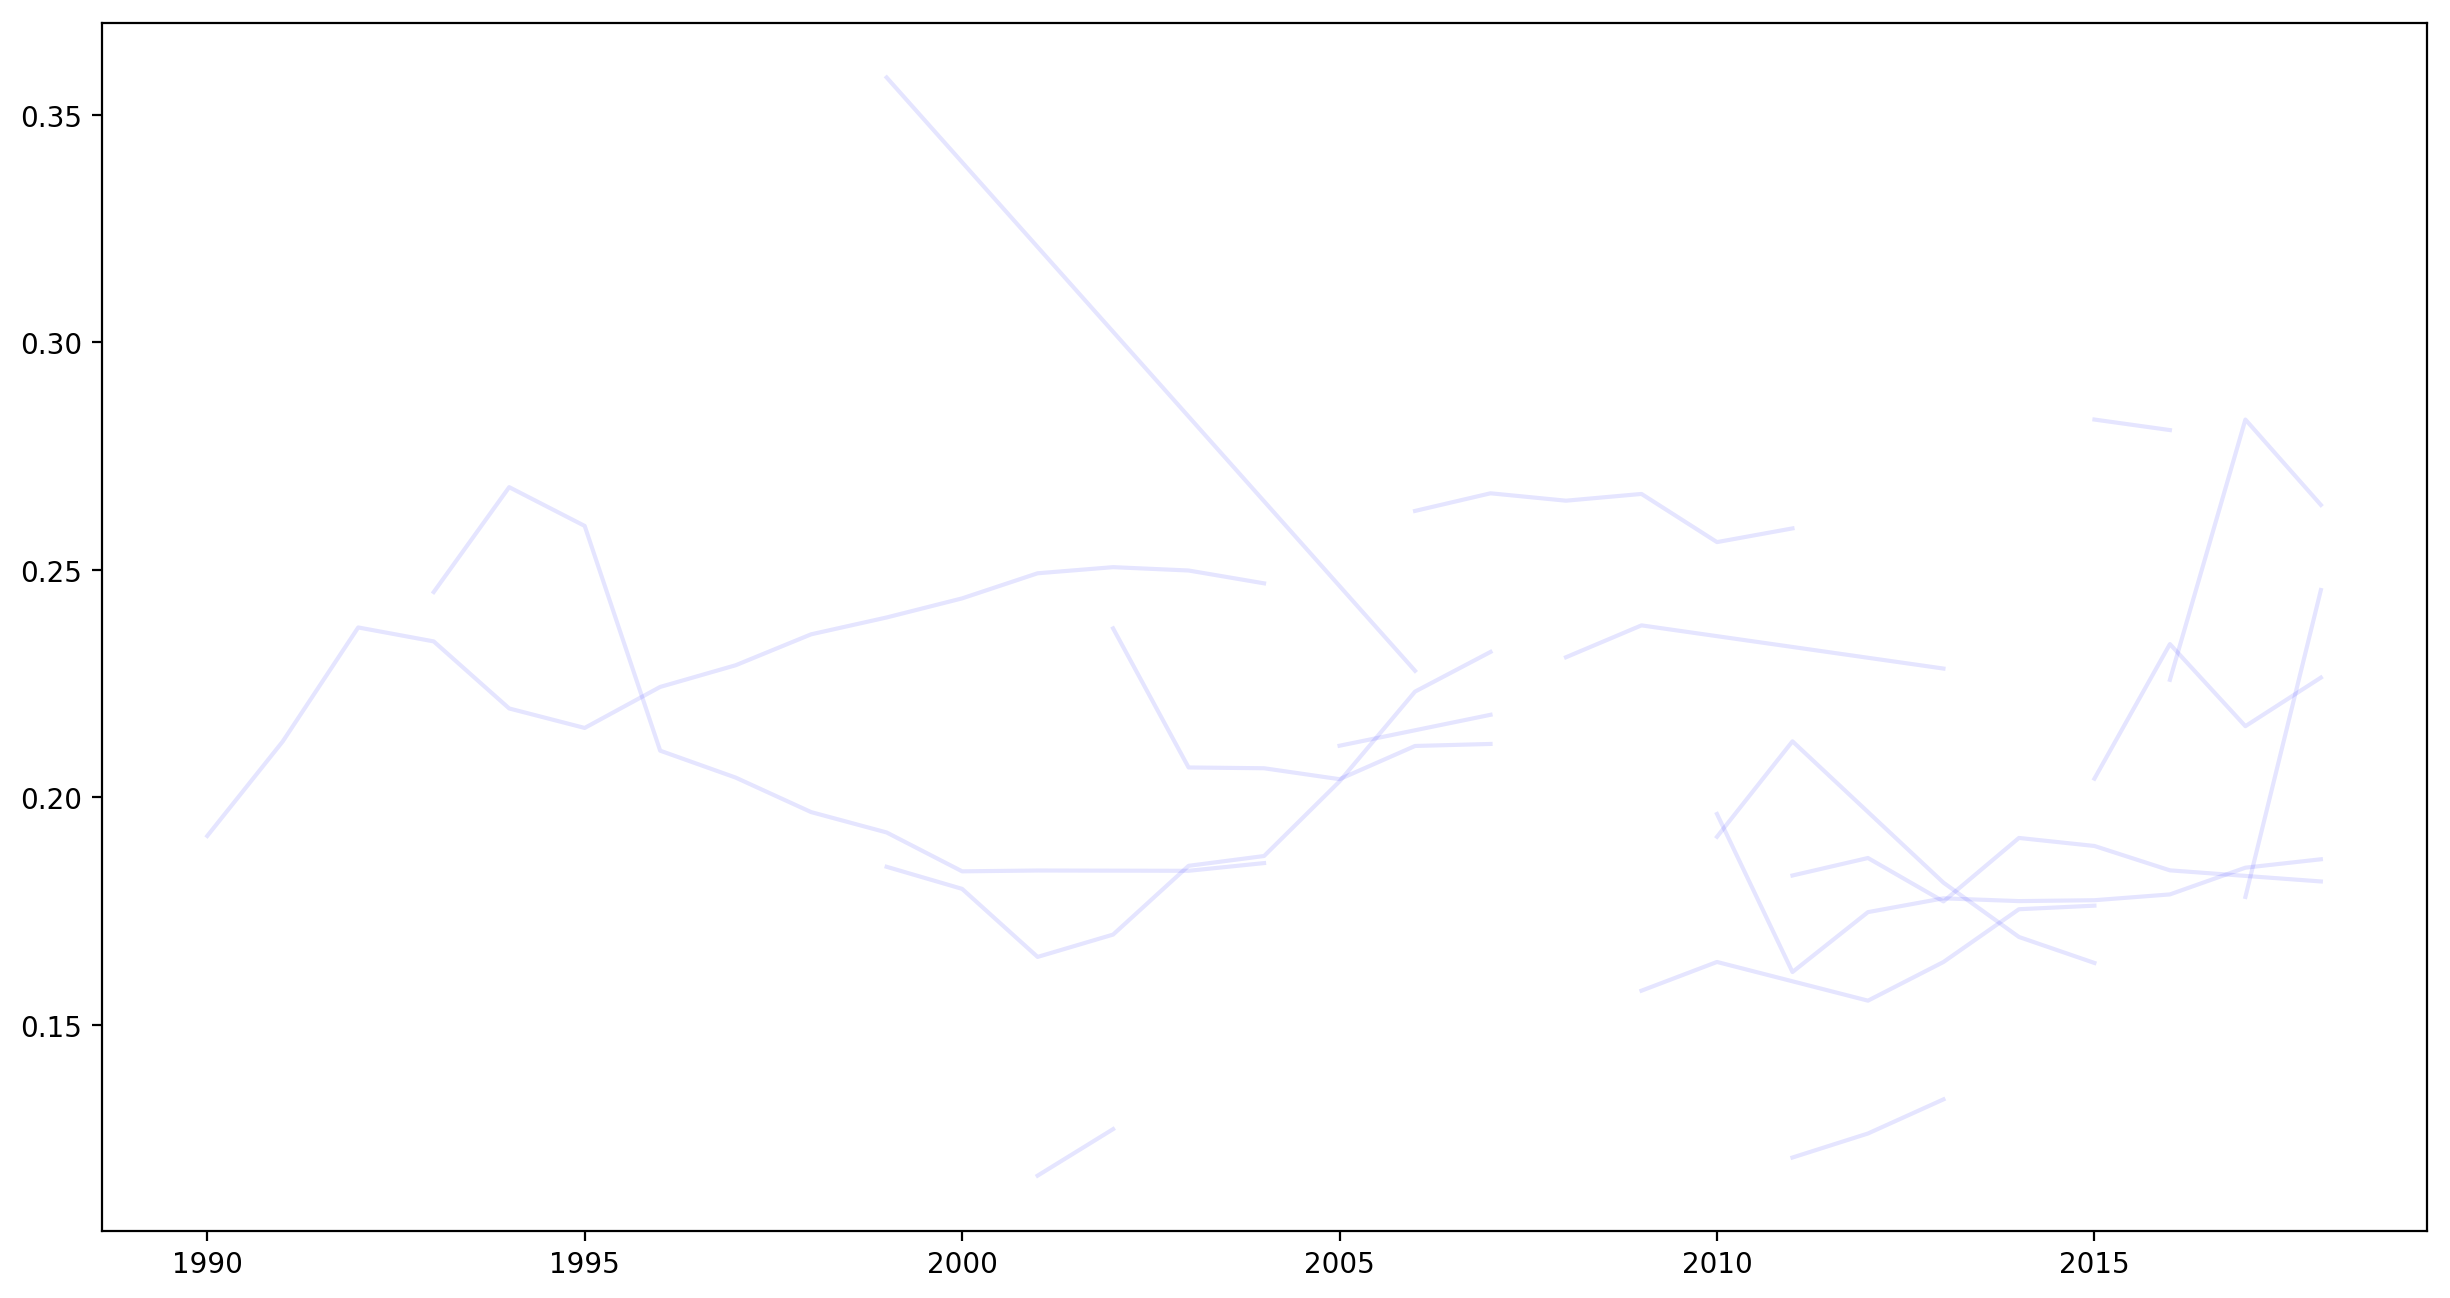

In [355]:
fig, ax1= plt.subplots(figsize=(15,8), dpi=200)
for pitcher in list(set(pit_['pitcher_id'].tolist())):
    single_pit = pit_[pit_['pitcher_id'] == pitcher]
    single_pit['avg'] = single_pit['hits']/single_pit['ab']
    X = single_pit['year']
    Y = single_pit['avg']
    ax1.plot(X, Y, alpha=.1, color='blue')

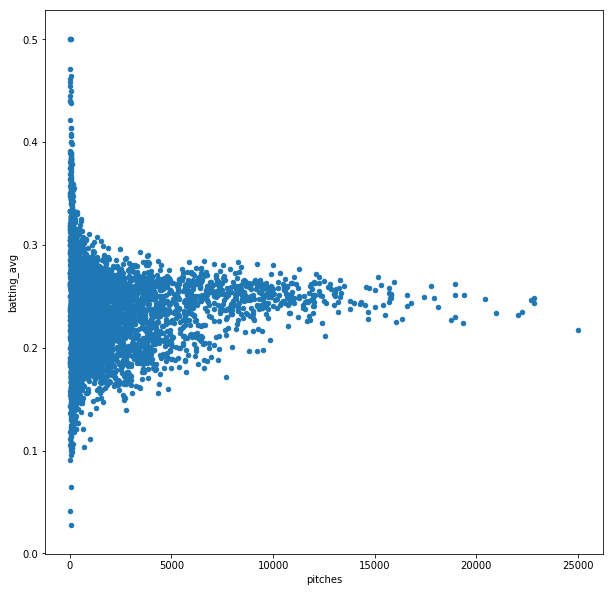

In [243]:
f_[f_['pitches'] > 20].plot(kind='scatter',
                            x='pitches',
                            y='batting_avg',
                            figsize=(10,10),
                            alpha=1)

In [241]:
final.shape

(9832396, 12)